In [1]:
import sys
sys.path.append("C:/Users/mason/Desktop/Brown/Reintergrating-AI/mbrl-lib-SINDy")


In [2]:
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns

# all the mbrl.models sub-class the
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

from REAI.physics_models import SINDyModel, CartpoleModel
from REAI.physics_models import trajectories_from_replay_buffer
#from utils import check_physics_model


device = "cuda:0" if torch.cuda.is_available() else "cpu"

trial_length = 1000
num_trials = 10
ensemble_size = 5
rendering = True
seed = 0


physics_config = {
    'phys_nn_config' : 1,                   
    # options:  
    # 0: no physics model, only pets
    # 1: additive composition: 
    #    mean = physics_model(x) + Pets(x), logvar = Pets(x) 
    # 2: physics model prediction pass through pets
    #   mean, logvar = NN(concat(physics_model.predict(state, action), state, action)
    #3: only physics model, no NN
    'physics_model' : 'sindy',               
    # options: sindy/cartpole
    'model_kwargs' : { 'backend' : 'sindy',
                       'noise_level' : 0.0 , 
                       'predict_delta' : True} , 
    # options for sindy: 'backend' : 'torch', 'sindy', 'dask'

    }


# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",  # NOTE: important we are using a GAUSSIANMLP Here --
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "in_features": "???",
        "out_size": "???",
        "deterministic": False,  # probabilistic model
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {"_target_": "torch.nn.LeakyReLU", "negative_slope": 0.01},
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": False,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05,
    },
}

agent_cfg = omegaconf.OmegaConf.create(
    {
        # this class evaluates many trajectories and picks the best one
        "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
        "planning_horizon": 15,
        "replan_freq": 1,
        "verbose": False,
        "action_lb": "???",
        "action_ub": "???",
        # this is the optimizer to generate and choose a trajectory
        "optimizer_cfg": {
            "_target_": "mbrl.planning.CEMOptimizer",
            "num_iterations": 5,
            "elite_ratio": 0.1,
            "population_size": 500,
            "alpha": 0.1,
            "device": device,
            "lower_bound": "???",
            "upper_bound": "???",
            "return_mean_elites": True,
            "clipped_normal": False,
            #for iCEM
            #"keep_elite_frac" : 0.1,
            #"population_decay_factor":  0.9, 
            #"colored_noise_exponent": 0.5,
        },
    }
)


#def run():
env = cartpole_env.CartPoleEnv()
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole


phys_nn_config = physics_config['phys_nn_config']
physics_model = physics_config['physics_model']

if phys_nn_config == 2:
    cfg_dict["dynamics_model"]["in_features"] = 2 * obs_shape[0] + (act_shape[0] if act_shape else 1)
    print('overriding in_features to ', cfg_dict["dynamics_model"]["in_features"])

if phys_nn_config == 3:
    cfg_dict["dynamics_model"]["deterministic"] = True
    print('overriding deterministic to True')

cfg = omegaconf.OmegaConf.create(cfg_dict)

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)
dynamics_model.model.phys_nn_config = phys_nn_config

if physics_model == 'sindy':
    dynamics_model.model.physics_model = SINDyModel(**physics_config['model_kwargs']) # change backend to 'torch' to run on GPU

elif physics_model == 'cartpole':
    dynamics_model.model.physics_model = CartpoleModel(**physics_config['model_kwargs'])


# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(
    env, dynamics_model, term_fn, reward_fn, generator=generator
)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

common_util.rollout_agent_trajectories(
    env,
    trial_length,  # initial exploration steps
    planning.RandomAgent(env),
    {},  # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length,
)


# pretrain Sindy model on random trajectories
if isinstance(dynamics_model.model.physics_model, SINDyModel):
    dynamics_model.model.physics_model.train(replay_buffer)

In [3]:
trajectories_list, action_list = trajectories_from_replay_buffer(replay_buffer)
test_trajectory = max(trajectories_list, key=len)

print(np.shape(test_trajectory))
#print(max_index)


# samples stored 1000
total steps:  1000
(97, 4)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def check_physics_model(replay_buffer, physics_model):
    """
    physics_model = dynamics_model.model.physics_model
    """

    trajectories_list, action_list = trajectories_from_replay_buffer(replay_buffer)
    # trajectories_list = trajectories_list
    # action_list = action_list
    
    test_trajectory = trajectories_list[1][:5]
    test_actions = action_list[1][:5]

    predicted_states = []
    predicted_states_own = []
    sim_states = [test_trajectory[0]]

    for i in range(len(test_trajectory)):
        state = torch.tensor(test_trajectory[i], dtype=torch.float32)
        action = torch.tensor(test_actions[i], dtype=torch.float32)

        sim_state = sim_states[-1]
        print(i, state, action)

        # Predicting recursively (from its own prediction)
        pred_next = np.array(physics_model.predict(torch.tensor(sim_state, dtype=torch.float32), action))
        predicted_states_own.append(pred_next)
        sim_states.append(pred_next)

        # Predicting from actual state
        next_state = np.array(physics_model.predict(state, action))
        predicted_states.append(next_state)

    predicted_states = np.array(predicted_states)
    predicted_states_own = np.array(predicted_states_own)

    print(predicted_states.shape)
    plt.figure()
    state_dims = state.shape[0]
    for j in range(state_dims):
        plt.subplot(state_dims, 2, 2*j + 1)
        plt.plot(predicted_states[:-1, j], label='model prediction from state')
        plt.plot(predicted_states_own[:-1, j], label='model prediction recursive')
        plt.plot(test_trajectory[1:, j], label='true trajectory')
        if j == state_dims - 1:
            plt.legend()

        plt.subplot(state_dims, 2, 2 * j + 2)
        plt.plot(np.abs(predicted_states[:-1, j] - test_trajectory[1:, j]), label='model prediction from state')
        plt.plot(np.abs(predicted_states_own[:-1, j] - test_trajectory[1:, j]), label='model prediction recursive')
        plt.title('Errors')
    plt.show()

    return predicted_states, predicted_states_own


# samples stored 1000
total steps:  1000
0 tensor([-0.0398,  0.0173, -0.0107,  0.0170]) tensor([0.5328])
1 tensor([-0.0394,  0.1126, -0.0104, -0.1423]) tensor([0.4300])
2 tensor([-0.0372,  0.1896, -0.0132, -0.2714]) tensor([0.3372])
3 tensor([-0.0334,  0.2500, -0.0187, -0.3742]) tensor([0.2125])
4 tensor([-0.0284,  0.2882, -0.0262, -0.4420]) tensor([0.0719])
(5, 4)


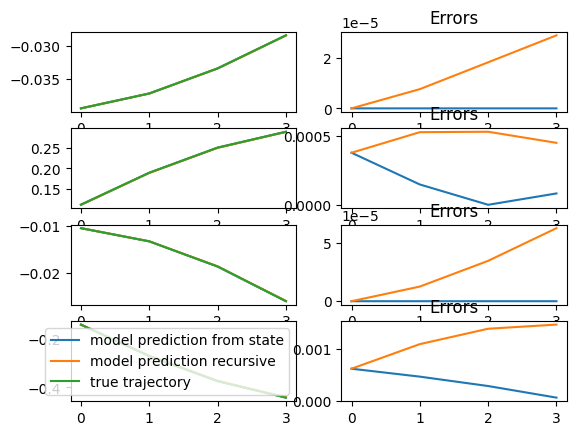

num stored 1000
# samples stored 1000
[[-0.03940543  0.11223884 -0.01040263 -0.14171386]
 [-0.03715307  0.18941267 -0.01324943 -0.27096686]
 [-0.03336184  0.24995987 -0.01867823 -0.37389272]
 [-0.02836262  0.28824505 -0.02616194 -0.44197342]
 [-0.0225994   0.30145887 -0.03500279 -0.47117123]]
[[-0.03940543  0.11223884 -0.01040263 -0.14171386]
 [-0.03716066  0.18903272 -0.01323691 -0.27034077]
 [-0.03338001  0.24942927 -0.01864372 -0.37278944]
 [-0.02839143  0.2877103  -0.0260995  -0.44056708]
 [-0.02263723  0.30100405 -0.03491084 -0.46967643]]


In [5]:
predicted_states, predicted_states_own = check_physics_model(replay_buffer, dynamics_model.model.physics_model)
print("num stored", replay_buffer.num_stored)
print("# samples stored", replay_buffer.num_stored)

print(predicted_states)  
print(predicted_states_own)

In [7]:
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

dynamics_model.update_normalizer(
    replay_buffer.get_all()
)  # update normalizer stats


train_losses = []
val_scores = []


def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(
        val_score.mean().item()
    )  # this returns val score per ensemble model

# bootsrapped
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)
if phys_nn_config != 3:
    model_trainer.train(
        dataset_train,
        dataset_val=dataset_val,
        num_epochs=2,
        patience=50,
        callback=train_callback,
        silent=False,
    )

AttributeError: 'SINDyModel' object has no attribute 'input_normalizer'

In [ ]:
trajectories_list, action_list = dynamics_model.model.physics_model.extract_data_from_buffer(dataset_val)

In [ ]:
dynamics_model.model.physics_model.simulate


<bound method SINDyModel.simulate of <REAI.physics_models.SINDyModel object at 0x00000220A74C0CD0>>

In [ ]:
sin  = SINDyModel()
sin.simulate

<bound method SINDyModel.simulate of <REAI.physics_models.SINDyModel object at 0x00000220A74C14E0>>

In [ ]:
import inspect

type(dynamics_model.model.physics_model)


type(sin)
#MyClass = dynamics_model.model.physics_model
MyClass = sin
methods = inspect.getmembers(MyClass, predicate=inspect.ismethod)
print(dir(MyClass))

# print the names of the methods
for method in methods:
    print(method[0])

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_predict_with_torch', '_run_with_dask', 'backend', 'der', 'equations_to_pytorch', 'eval_model', 'eval_replay_buffer', 'extract_data_from_buffer', 'functions', 'inputs_normalizer', 'lib', 'model', 'noise_level', 'optimizer', 'predict', 'predict_delta', 'print_model', 'rollout_trajectory', 'simulate', 'sindy_calls', 'torch_functions', 'train']
__init__
_predict_with_torch
_run_with_dask
equations_to_pytorch
eval_model
eval_replay_buffer
extract_data_from_buffer
predict
rollout_trajectory
simulate
train


In [ ]:
#print(f'Number of Sindy Calls:', dynamics_model.model.sindy_call_count)

In [ ]:
def initialize_model(phys_config,trial_length=None):

    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    if trial_length is None:
        trial_length = 200
    
    num_trials = 10
    ensemble_size = 5
    rendering = True
    seed = 0


    physics_config = {
        'phys_nn_config' : phys_config,                   
        # options:  
        # 0: no physics model, only pets
        # 1: additive composition: 
        #    mean = physics_model(x) + Pets(x), logvar = Pets(x) 
        # 2: physics model prediction pass through pets
        #   mean, logvar = NN(concat(physics_model.predict(state, action), state, action)
        #3: only physics model, no NN
        'physics_model' : 'sindy',               
        # options: sindy/cartpole
        'model_kwargs' : { 'backend' : 'sindy',
                        'noise_level' : 0.0 , 
                        'predict_delta' : True} , 
        # options for sindy: 'backend' : 'torch', 'sindy', 'dask'

        }

    # Everything with "???" indicates an option with a missing value.
    # Our utility functions will fill in these details using the
    cfg_dict = {
        # dynamics model configuration
        "dynamics_model": {
            "_target_": "mbrl.models.GaussianMLP",  # NOTE: important we are using a GAUSSIANMLP Here --
            "device": device,
            "num_layers": 3,
            "ensemble_size": ensemble_size,
            "hid_size": 200,
            "in_size": "???",
            "in_features": "???",
            "out_size": "???",
            "deterministic": False,  # probabilistic model
            "propagation_method": "fixed_model",
            # can also configure activation function for GaussianMLP
            "activation_fn_cfg": {"_target_": "torch.nn.LeakyReLU", "negative_slope": 0.01},
        },
        # options for training the dynamics model
        "algorithm": {
            "learned_rewards": False,
            "target_is_delta": True,
            "normalize": False,
        },
        # these are experiment specific options
        "overrides": {
            "trial_length": trial_length,
            "num_steps": num_trials * trial_length,
            "model_batch_size": 32,
            "validation_ratio": 0.05,
        },
    }

    agent_cfg = omegaconf.OmegaConf.create(
        {
            # this class evaluates many trajectories and picks the best one
            "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
            "planning_horizon": 15,
            "replan_freq": 1,
            "verbose": False,
            "action_lb": "???",
            "action_ub": "???",
            # this is the optimizer to generate and choose a trajectory
            "optimizer_cfg": {
                "_target_": "mbrl.planning.CEMOptimizer",
                "num_iterations": 5,
                "elite_ratio": 0.1,
                "population_size": 500,
                "alpha": 0.1,
                "device": device,
                "lower_bound": "???",
                "upper_bound": "???",
                "return_mean_elites": True,
                "clipped_normal": False,
                #for iCEM
                #"keep_elite_frac" : 0.1,
                #"population_decay_factor":  0.9, 
                #"colored_noise_exponent": 0.5,
            },
        }
    )


    #def run():
    env = cartpole_env.CartPoleEnv()
    env.seed(seed)
    rng = np.random.default_rng(seed=0)
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    obs_shape = env.observation_space.shape
    act_shape = env.action_space.shape

    # This functions allows the model to evaluate the true rewards given an observation
    reward_fn = reward_fns.cartpole
    # This function allows the model to know if an observation should make the episode end
    term_fn = termination_fns.cartpole

    phys_nn_config = physics_config['phys_nn_config']
    physics_model = physics_config['physics_model']

    if phys_nn_config == 2:
        cfg_dict["dynamics_model"]["in_features"] = 2 * obs_shape[0] + (act_shape[0] if act_shape else 1)
        print('overriding in_features to ', cfg_dict["dynamics_model"]["in_features"])

    if phys_nn_config == 3:
        cfg_dict["dynamics_model"]["deterministic"] = True
        print('overriding deterministic to True')

    cfg = omegaconf.OmegaConf.create(cfg_dict)

    # Create a 1-D dynamics model for this environment
    dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)
    dynamics_model.model.phys_nn_config = phys_nn_config

    if physics_model == 'sindy':
        dynamics_model.model.physics_model = SINDyModel(**physics_config['model_kwargs']) # change backend to 'torch' to run on GPU

    elif physics_model == 'cartpole':
        dynamics_model.model.physics_model = CartpoleModel(**physics_config['model_kwargs'])


    # Create a gym-like environment to encapsulate the model
    model_env = models.ModelEnv(
        env, dynamics_model, term_fn, reward_fn, generator=generator
    )

    replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

    common_util.rollout_agent_trajectories(
        env,
        trial_length,  # initial exploration steps
        planning.RandomAgent(env),
        {},  # keyword arguments to pass to agent.act()
        replay_buffer=replay_buffer,
        trial_length=trial_length,
    )

    print(physics_config["phys_nn_config"], trial_length)
    print("# samples stored", replay_buffer.num_stored)
    print(type(dynamics_model.model),type(dynamics_model.model.physics_model))

    # pretrain Sindy model on random trajectories
    if isinstance(dynamics_model.model.physics_model, SINDyModel):
        dynamics_model.model.physics_model.train(replay_buffer)

    model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

    dynamics_model.update_normalizer(
        replay_buffer.get_all()
    )  # update normalizer stats


    train_losses = []
    val_scores = []


    def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
        train_losses.append(tr_loss)
        val_scores.append(
            val_score.mean().item()
        )  # this returns val score per ensemble model

    # bootsrapped
    dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
        replay_buffer,
        batch_size=cfg.overrides.model_batch_size,
        val_ratio=cfg.overrides.validation_ratio,
        ensemble_size=ensemble_size,
        shuffle_each_epoch=True,
        bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
    )
    if phys_nn_config != 3:
        model_trainer.train(
            dataset_train,
            dataset_val=dataset_val,
            num_epochs=150,
            patience=50,
            callback=train_callback,
            silent=False,
        )
    


    #print(f'Number of Sindy Calls:', dynamics_model.model.sindy_call_count)
    return train_losses, val_scores



In [ ]:
#loop over physics configs
loss_list = []
val_list = []

for phys_nn_config in range(0,4):
  print( phys_nn_config)
  train_losses, val_scores  = initialize_model(phys_nn_config)
  loss_list.append(train_losses)
  val_list.append(val_scores)



0
0 200
# samples stored 200
<class 'mbrl.models.gaussian_mlp.GaussianMLP'> <class 'REAI.physics_models.SINDyModel'>


AttributeError: 'SINDyModel' object has no attribute 'input_normalizer'

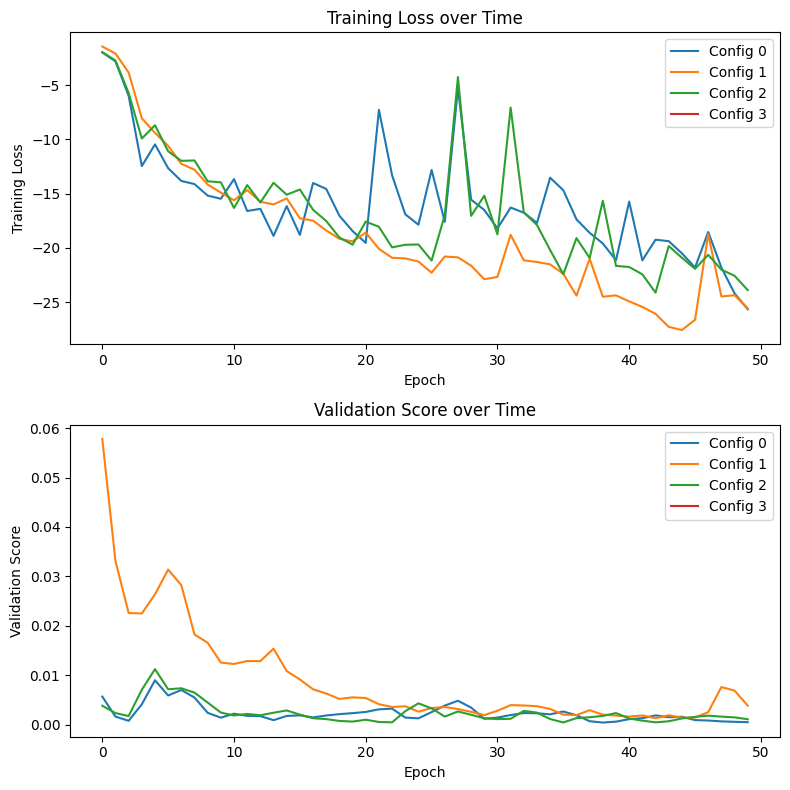

In [ ]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# plot all the train_losses on the first subplot
for i, train_losses in enumerate(loss_list):
    ax1.plot(train_losses, label=f'Config {i}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss over Time')
ax1.legend()

# plot all the val_scores on the second subplot
for i, val_scores in enumerate(val_list):
    ax2.plot(val_scores, label=f'Config {i}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Score')
ax2.set_title('Validation Score over Time')
ax2.legend()

# adjust the layout of the subplots
fig.tight_layout()

# show the plot
plt.show()

In [ ]:
loss_list = []
val_list = []

trials_list = [4, 10, 70, 120, 200]

for trials in trials_list:
    loss_sublist = []
    val_sublist = []
    
    for phys_nn_config in range(0,4):
        train_losses, val_scores = initialize_model(phys_nn_config, trials)
        loss_sublist.append(train_losses)
        val_sublist.append(val_scores)
    
    loss_list.append(loss_sublist)
    val_list.append(val_sublist)

0 4
# samples stored 4


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


1 4
# samples stored 4


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


overriding in_features to  9
2 4
# samples stored 4


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


overriding deterministic to True
3 4
# samples stored 4
0 10
# samples stored 10


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


1 10
# samples stored 10


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


overriding in_features to  9
2 10
# samples stored 10


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


overriding deterministic to True
3 10
# samples stored 10
0 70
# samples stored 70


c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


1 70
# samples stored 70
overriding in_features to  9
2 70
# samples stored 70
overriding deterministic to True
3 70
# samples stored 70
0 120
# samples stored 120
1 120
# samples stored 120
overriding in_features to  9
2 120
# samples stored 120
overriding deterministic to True
3 120
# samples stored 120
0 200
# samples stored 200
1 200
# samples stored 200
overriding in_features to  9
2 200
# samples stored 200
overriding deterministic to True
3 200
# samples stored 200


In [ ]:
fig, axes = plt.subplots(nrows=len(trials_list), ncols=2, figsize=(12, 20))

for trial_idx, trials in enumerate(trials_list):
    for config_idx in range(4):
        axes[trial_idx][0].plot(loss_list[trial_idx][config_idx], label=f'Config {config_idx}')
        axes[trial_idx][1].plot(val_list[trial_idx][config_idx], label=f'Config {config_idx}')

    axes[trial_idx][0].set_title(f'Training Loss for Trials: {trials}')
    axes[trial_idx][0].set_xlabel('Epoch')
    axes[trial_idx][0].set_ylabel('Training Loss')
    axes[trial_idx][0].legend()

    axes[trial_idx][1].set_title(f'Validation Score for Trials: {trials}')
    axes[trial_idx][1].set_xlabel('Epoch')
    axes[trial_idx][1].set_ylabel('Validation Score')
    axes[trial_idx][1].legend()

fig.tight_layout()
plt.show()

NameError: name 'trials_list' is not defined

# samples stored 1000
total steps:  1000
(53, 4)
(53, 4)
(53, 4)
full rollout: (53, 4)


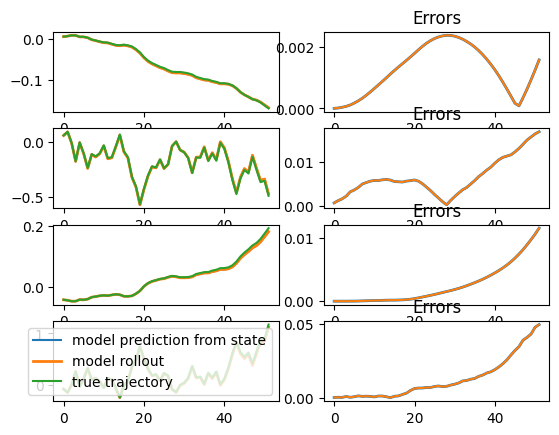

In [ ]:
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

trajectories_list, action_list = trajectories_from_replay_buffer(replay_buffer)
m = max(range(len(trajectories_list)), key=lambda i: len(trajectories_list[i]))

test_trajectory = trajectories_list[m]
test_actions = action_list[m]
initial_state = test_trajectory[0]

pred_sim = dynamics_model.model.physics_model.model.simulate(initial_state, len(test_trajectory)+1, u=test_actions)
predicted_states = np.array(pred_sim[1:])

cur_state = initial_state
cur_state = torch.tensor(cur_state)
cur_state_dyn = torch.tensor(cur_state)


rollout = []
rollout.append(np.array(cur_state))

full_rollout =[]
full_rollout.append(np.array(cur_state_dyn))

def gen_samples():
    x = torch.cat((state, action), dim=1)
    #print(x.shape)
    mean, logvar = dynamics_model.model._default_forward(x)
    mean = torch.mean(mean, dim=0)
    logvar = torch.mean(logvar, dim=0)

    var = torch.exp(logvar)

    # print the shapes of the tensors
    #print("Mean shape:", mean.shape)
    #print("Variance shape:", var.shape)
    # create a covariance matrix from the variance
    cov = torch.diag_embed(var)
    #print(cov)
    #print("Covariance shape:", cov.shape)

    # create a multivariate normal distribution with mean and covariance
    mvn = MultivariateNormal(mean.squeeze(), covariance_matrix=cov)
    cur_state_dyn =  mvn.sample()
    return cur_state_dyn

for i in range(len(test_trajectory)):
    # Predicting recursively (from its own prediction)
    action = torch.tensor(test_actions[i]).unsqueeze(0)
    state =  torch.tensor(cur_state, dtype=torch.float32).unsqueeze(0)
    state1 = torch.tensor(cur_state_dyn, dtype=torch.float32).unsqueeze(0)
    #print(state.shape,action.shape)



    #print('next_state_dyn: ', cur_state_dyn.shape)
    full_rollout.append(np.array(cur_state_dyn))
    #print('full rollout:', np.shape(full_rollout))


    #cur_state = dynamics_model.model.physics_model.model.predict(state, u=action)
    cur_state = dynamics_model.model.physics_model.predict(torch.tensor(cur_state, dtype=torch.float32), torch.tensor(test_actions[i]))
    #print(state.shape,action.shape)

    #print('pred_shape', cur_state.shape)
    #rollout1.append(np.array(cur_state))
    cur_state = torch.tensor(cur_state).squeeze()

    #print(cur_state.shape)
    rollout.append(np.array(cur_state))

full_rollout = np.array([sample for sample in full_rollout[1:]])
full_rollout = np.squeeze(full_rollout)

rollout = np.array(rollout[1:])
print(predicted_states.shape)
print(test_trajectory.shape)
print(rollout.shape)
print('full rollout:', full_rollout.shape)

plt.figure()
state_dims = 4
for j in range(state_dims):
    plt.subplot(state_dims, 2, 2*j + 1)
    plt.plot(predicted_states[:-1, j], label='model prediction from state')
    plt.plot(rollout[:-1, j], label='model rollout', linewidth=2)
    #plt.plot(full_rollout[:-1, j], label='full rollout', linewidth=3, alpha=0.5)
    plt.plot(test_trajectory[1:, j], label='true trajectory')
    if j == state_dims - 1:
        plt.legend()

    plt.subplot(state_dims, 2, 2 * j + 2)
    plt.plot(np.abs(rollout[:-1, j] - test_trajectory[1:, j]), label='rollout error', linewidth=2)
    plt.plot(np.abs(predicted_states[:-1, j] - test_trajectory[1:, j]), label='model prediction from state')
    plt.title('Errors')
plt.show()

In [ ]:
import numpy as np
import torch
import copy
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

num_particles = 5  # Set the desired number of particles

trajectories_list, action_list = trajectories_from_replay_buffer(replay_buffer)
m = max(range(len(trajectories_list)), key=lambda i: len(trajectories_list[i]))

test_trajectory = trajectories_list[m]
test_actions = action_list[m]
initial_state = test_trajectory[0]

pred_sim = dynamics_model.model.physics_model.model.simulate(initial_state, len(test_trajectory)+1, u=test_actions)
predicted_states = np.array(pred_sim[1:])

cur_state = initial_state
cur_state = torch.tensor(cur_state)
cur_state_dyn = torch.tensor(cur_state)

rollout = []
rollout.append(np.array(cur_state))

def gen_samples(state, action):
    x = torch.cat((state, action), dim=1)

    #mean / logvar of delta of next state
    mean, logvar = dynamics_model.model._default_forward(x)
    mean = torch.mean(mean, dim=0)
    logvar = torch.mean(logvar, dim=0)
    var = torch.exp(logvar)
    cov = torch.diag_embed(var)
    mvn = MultivariateNormal(mean.squeeze(), covariance_matrix=cov)
    next_state = mvn.sample() + state
    return next_state, cov


for i in range(len(test_trajectory)):
    action = torch.tensor(test_actions[i]).unsqueeze(0)
    state = torch.tensor(cur_state, dtype=torch.float32).unsqueeze(0)
    cur_state = dynamics_model.model.physics_model.predict(state, action)
    cur_state = torch.tensor(cur_state).squeeze()
    rollout.append(np.array(cur_state))

rollout = np.array(rollout[1:])

# Code to generate multiple full_rollouts
full_rollouts = []
covar_data = []

for _ in range(num_particles):
    initial_state = copy.deepcopy(test_trajectory[0])
    print(initial_state)
    cur_state_dyn = torch.tensor(initial_state)
    full_rollout = [np.array(cur_state_dyn)]
    covar_rollout = []

    for i in range(len(test_trajectory)):
        action = torch.tensor(test_actions[i]).unsqueeze(0)
        state_dyn = torch.tensor(cur_state_dyn, dtype=torch.float32).unsqueeze(0)
        cur_state_dyn, covar = gen_samples(state_dyn, action)
        cur_state_dyn = cur_state_dyn.squeeze(0)
        full_rollout.append(np.array(cur_state_dyn))
        covar_rollout.append(covar.detach().numpy().diagonal(axis1=1, axis2=2).squeeze())

    full_rollouts.append(full_rollout)
    covar_data.append(covar_rollout)

full_rollouts = np.array(full_rollouts)
covar_data = np.array(covar_data)

# Plotting
state_dims = 4
plt.figure(figsize=(12, 2*state_dims))

for j in range(state_dims):
    plt.subplot(state_dims, 3, 3*j + 1)
    plt.plot(predicted_states[:-1, j], label='model prediction from state')
    plt.plot(rollout[:-1, j], label='model rollout', linewidth=2)

    for p in range(num_particles):
        plt.plot(full_rollouts[p][1:, j], label=f'full rollout {p+1}', linewidth=3, alpha=0.5)

    plt.plot(test_trajectory[1:, j], label='true trajectory')
    if j == state_dims - 1:
        plt.legend()

    plt.subplot(state_dims, 3, 3 * j + 2)
    plt.plot(np.abs(rollout[:-1, j] - test_trajectory[1:, j]), label='rollout error', linewidth=2)
    plt.plot(np.abs(predicted_states[:-1, j] - test_trajectory[1:, j]), label='model prediction from state')
    plt.title('Errors')

    plt.subplot(state_dims, 3, 3 * j + 3)
    for p in range(num_particles):
        plt.plot(covar_data[p][:, j], label=f'covar particle {p+1}', linewidth=2)
    plt.title('Covariance Magnitude')

plt.show()

# samples stored 1000
total steps:  1000
[-0.04404944 -0.04521891 -0.00667473  0.03354183]


AttributeError: 'SINDyModel' object has no attribute 'input_normalizer'